# X-Ray Binary Outburst Metric
Eric Bellm

This metric uses a pre-generated 3D distribution of Galactic LMXBs (after [Johnson+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484...19J)) and an analytic fast-rise, exponential decay model (after [Chen+97](https://ui.adsabs.harvard.edu/abs/1997ApJ...491..312C/abstract)) to assess LSST's ability to identify XRBs early in their outburst stages.  Absolute magnitudes are derived from orbital periods presented in [Casares 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.473.5195C).

The metric computes the fraction of events detected by LSST during the early outburst phase (enabling multiwavelength followup) as well as the total number of detectable events.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
from rubin_sim.data import get_baseline
from rubin_sim.phot_utils import DustValues

The XRB outburst metric is derived from the Kilonova metric. The key elements are a metric -- which defines the detection or characterization criteria for each event -- and a custom slicer -- which defines the locations and lightcurves for the events. 

The slicer is a UserPointsSlicer, with additional information tied to each slicePoint. A UserSlicePoint lets the user define RA/Dec values for the slicePoints over the sky (the locations of each event). This is then augmented by additional information on *when* the events happens and what the lightcurve looks like (or any other information about each event), tied to each slicePoint. Each slicePoint then represents each event. The slicer is set up by a function related to the metric called something like `generateXRBPopSlicer`  -- this function read information about the lightcurves and where they should be distributed, sets up the UserPointSlicer with that RA/Dec information, and then adds lightcurve information as appropriate.

The metric then gets the information about the observations at each slicePoint (each RA/Dec value) as well as the slicePoint information related to the lightcurve (such as the time of the peak or the shape of the event, etc) -- the brightness at the time of each observation is generally up to the metric to calculate or interpolate as it will depend on the timing of the observations from the simulation. The metric evaluates the observed points on the lightcurve against its criteria for discovery or characterization, etc. and returns an appropriate value. For some metrics this will be a simple 0/1 (discovered or not) but for other metrics it might be something like how accurately the lightcurve could be fit. 



## Set up and run the XRB metric. ## 

In [3]:
opsdb = get_baseline()
opsim = os.path.basename(opsdb).replace('.db','')
print(opsim)

baseline_v3.3_10yrs


In [4]:
n_events = 10000 
slicer = maf.generate_xrb_pop_slicer(n_events=n_events)

In [5]:
metric = maf.XRBPopMetric(output_lc=True)

# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metric_name='Total detected'), 
                  maf.CountMetric(metric_name='Total lightcurves in footprint'),
                  maf.CountMetric(metric_name='Total lightcurves on sky', mask_val=0),
                  maf.MeanMetric(metric_name='Fraction detected in footprint'), 
                  maf.MeanMetric(mask_val=0, metric_name='Fraction detected of total')]

In [6]:
bundle = maf.MetricBundle(metric, slicer, None, run_name=opsim, summary_metrics=summaryMetrics)

In [7]:
outDir = 'test_xrb'
bdict = {'xrb': bundle}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)

In [8]:
%%time
g.run_all()

CPU times: user 1min 5s, sys: 2.01 s, total: 1min 7s
Wall time: 1min 8s


In [9]:
bdict.keys()

dict_keys(['xrb', 'XRBPopMetric_early_detect', 'XRBPopMetric_ever_detect', 'XRBPopMetric_mean_time_between_detections', 'XRBPopMetric_number_of_detections', 'XRBPopMetric_possible_to_detect'])

## Detection metrics

The detection metrics return 1 if the specific detection criteria are satisfied and 0 otherwise.

In [10]:
detect_keys = [k for k in bdict.keys() if k.startswith('XRB') and k.endswith('detect')]
detect_keys

['XRBPopMetric_early_detect',
 'XRBPopMetric_ever_detect',
 'XRBPopMetric_possible_to_detect']

In [11]:
# create boolean detection arrays for use later
wpossible = bdict['XRBPopMetric_possible_to_detect'].metric_values == 1
wever = bdict['XRBPopMetric_ever_detect'].metric_values == 1
wearly = bdict['XRBPopMetric_early_detect'].metric_values == 1

wmissed = wpossible & ~wever
wmissed_early = wpossible & ~wearly

In [12]:
pd.DataFrame([bdict[k].summary_values for k in detect_keys], 
             index=[k.replace('_', ' ') for k in detect_keys])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
XRBPopMetric early detect,610.0,9693,10000,0.062932,0.0610
XRBPopMetric ever detect,4623.0,9693,10000,0.476942,0.4623
XRBPopMetric possible to detect,8115.0,9693,10000,0.837202,0.8115


**We are most interested in the fraction detectable in the footprint.**

"Possible to detect" gives an (optimistic) fraction of outbursts that ever are above the nominal detection threshold, but doesn't consider daylight--it provides an upper limit for the other detection metrics.

The "ever detect" metric reports the fraction of events that are ever detected (at least twice).

The "early detect" metric gives the fraction of events detected twice within 7 days of the outburst start.

Ideally all of these metrics would be close to the "possible to detect" metric, implying good spatial and temporal coverage of the relevant regions of the Plane.  At least in this simulation we are only detecting ~20% of the potentially observable outbursts during the initial rising phase.

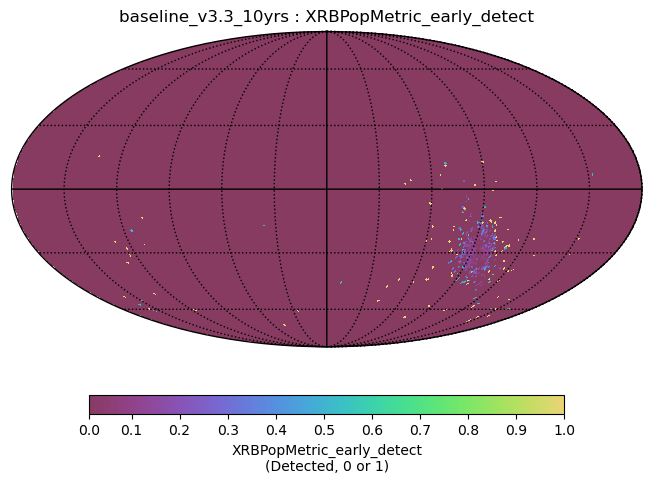

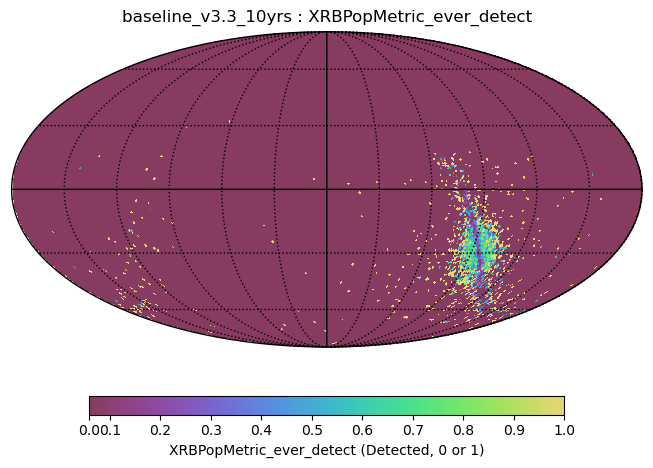

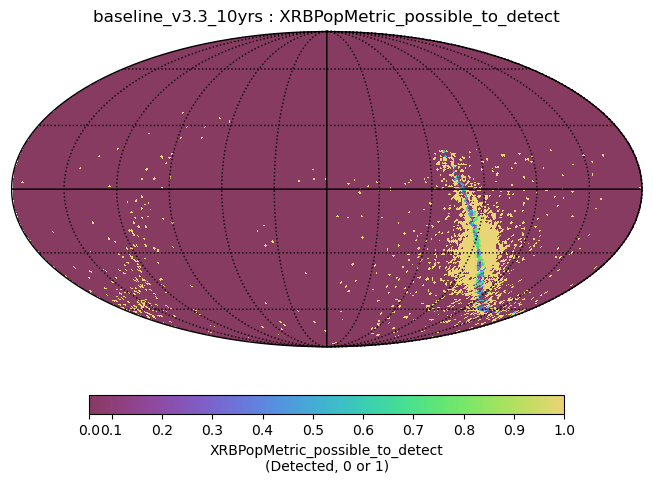

In [13]:
# Density plot of detection metrics
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(out_dir=outDir, fig_format='png', thumbnail=False)
for k in detect_keys:
    ph.set_metric_bundles([bdict[k]])
    ph.plot(plot_func=plotFunc, plot_dicts=plotDict)

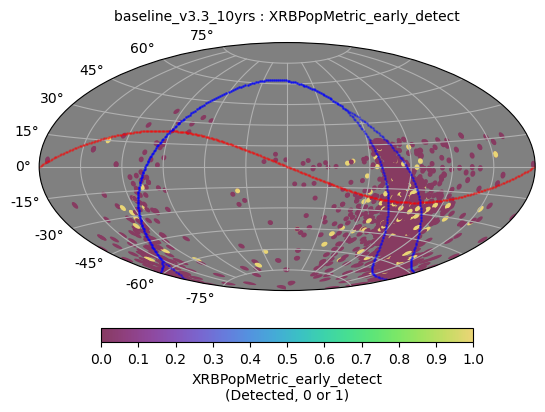

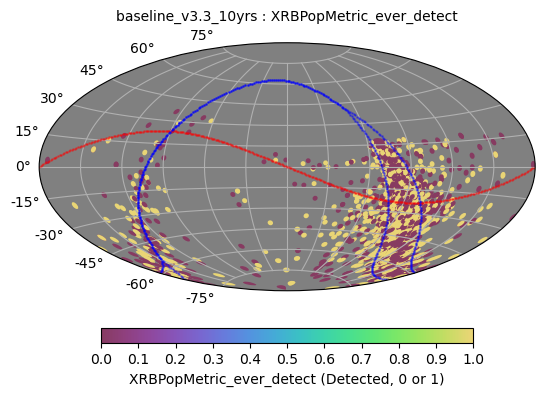

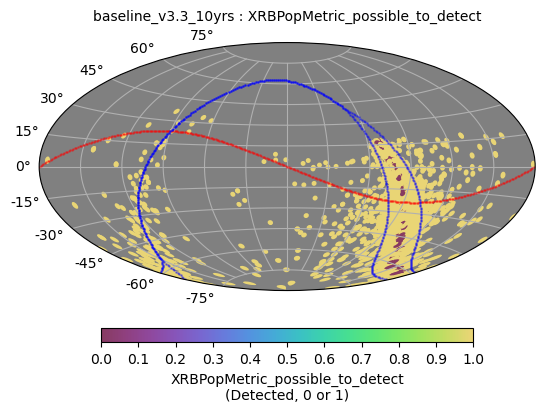

In [14]:
# Slower scatter plot of detection metrics
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(out_dir=outDir, fig_format='png', thumbnail=False)
for k in detect_keys:
    ph.set_metric_bundles([bdict[k]])
    ph.plot(plot_func=plotFunc)

## Sampling Metrics

For detected objects, we can assess the quality of the sampling by looking at the metrics for time spacing between observations as well as the number of detections.

In [15]:
char_keys = [k for k in bdict.keys() if k.startswith('XRB') and not k.endswith('detect')]
char_keys
pd.DataFrame([bdict[k].summary_values for k in char_keys], 
             index=[k.replace('_', ' ') for k in char_keys])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
XRBPopMetric mean time between detections,22005.336644,4623,10000,4.759969,2.200534
XRBPopMetric number of detections,43591.000000,9693,10000,4.497163,4.359100


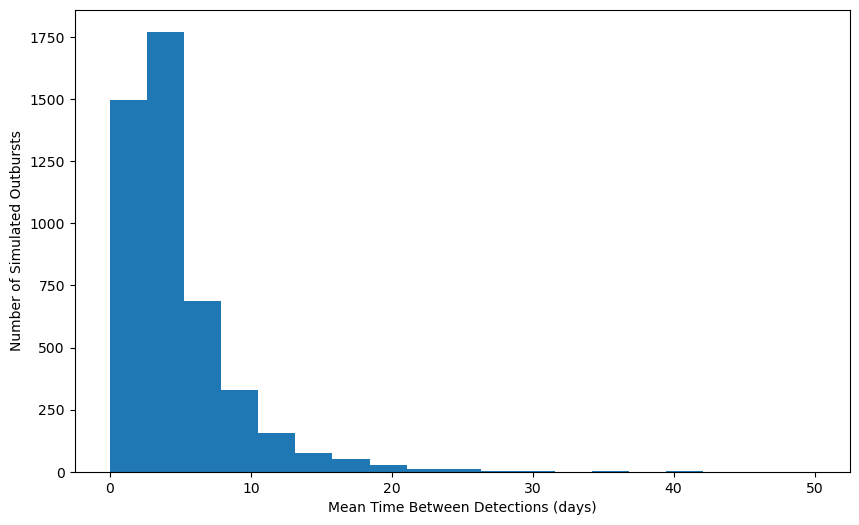

In [16]:
plt.figure(figsize=(10,6))
_=plt.hist(bdict['XRBPopMetric_mean_time_between_detections'].metric_values[wever], 
        bins = np.linspace(0,50,20))
_=plt.xlabel('Mean Time Between Detections (days)')
_=plt.ylabel('Number of Simulated Outbursts')

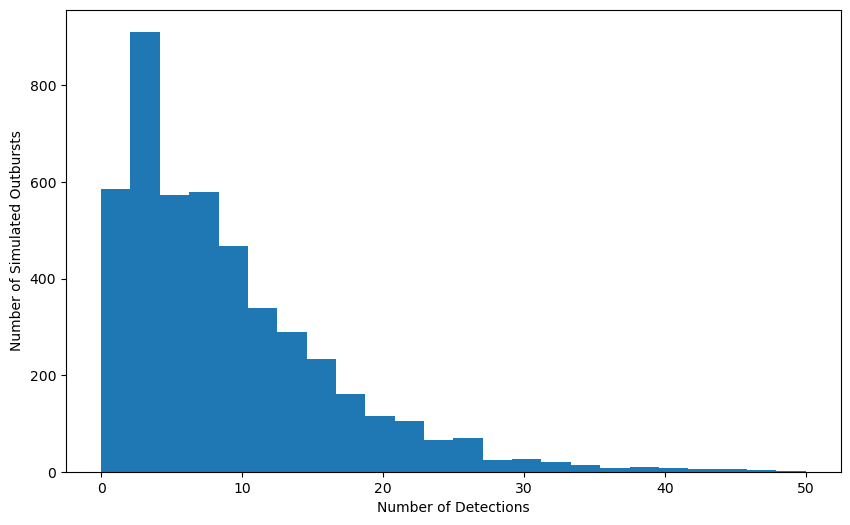

In [17]:
plt.figure(figsize=(10,6))
_=plt.hist(bdict['XRBPopMetric_number_of_detections'].metric_values[wever], 
        bins = np.linspace(0,50,25))
_=plt.xlabel('Number of Detections')
_=plt.ylabel('Number of Simulated Outbursts')

## Examining the simulated inputs

The slicer holds the slicePoint information, including the information about where the events occured and what the lightcurves looked like before adding observational information (i.e. in the model).  We can use these to explore trends in which outbursts are detected or not.

We begin by plotting the location of all the simulated outbursts:

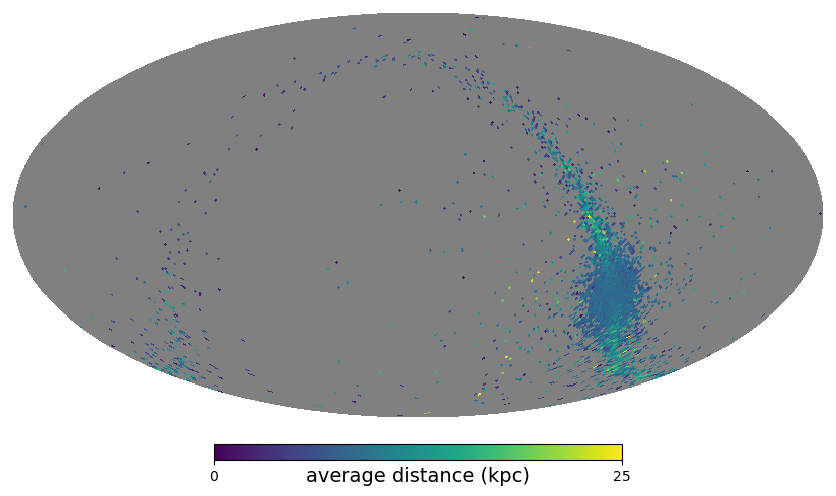

In [18]:
hp.mollview(rsUtils._healbin(slicer.slice_points['ra'], slicer.slice_points['dec'], 
                             slicer.slice_points['distance'], 64, reduce_func=np.mean), 
            unit='average distance (kpc)', title='', min=0, max=25)

### Where is more coverage needed?

Next we can assess where LSST coverage is missing--which outbursts should we have been able to detect, but weren't observed?

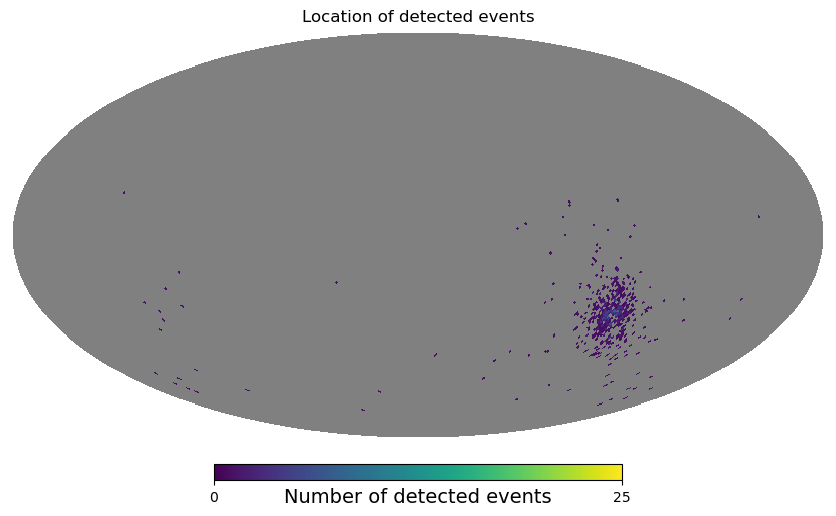

In [19]:
# Spatial distribution of observable events which were detected early
detected_early_map = rsUtils._healbin(slicer.slice_points['ra'][wearly], slicer.slice_points['dec'][wearly], 
                             np.ones(np.sum(wearly)), 64, reduce_func=np.sum)
hp.mollview(detected_early_map, 
            unit='Number of detected events', title='Location of detected events', min=0, max=25)

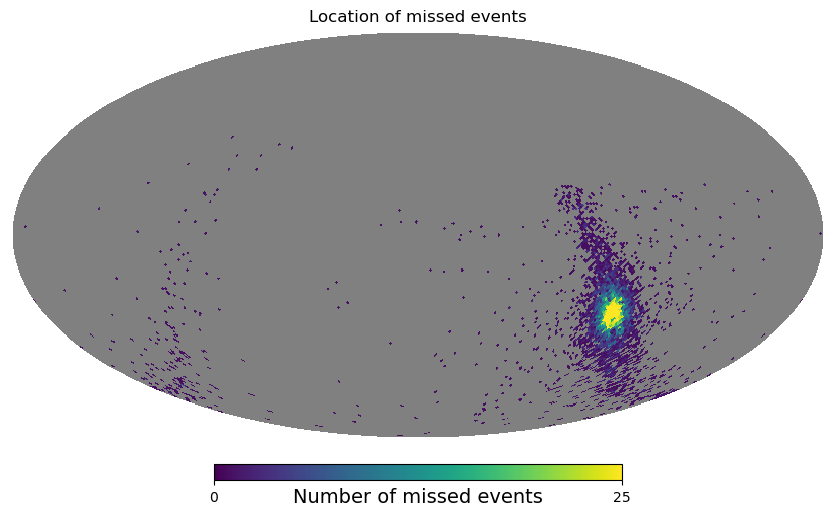

In [20]:
# Spatial distribution of observable events which were missed
missed_early_map = rsUtils._healbin(slicer.slice_points['ra'][wmissed_early],
                                    slicer.slice_points['dec'][wmissed_early], 
                             np.ones(np.sum(wmissed_early)), 64, reduce_func=np.sum)
hp.mollview(missed_early_map, 
            unit='Number of missed events', title='Location of missed events', min=0, max=25)

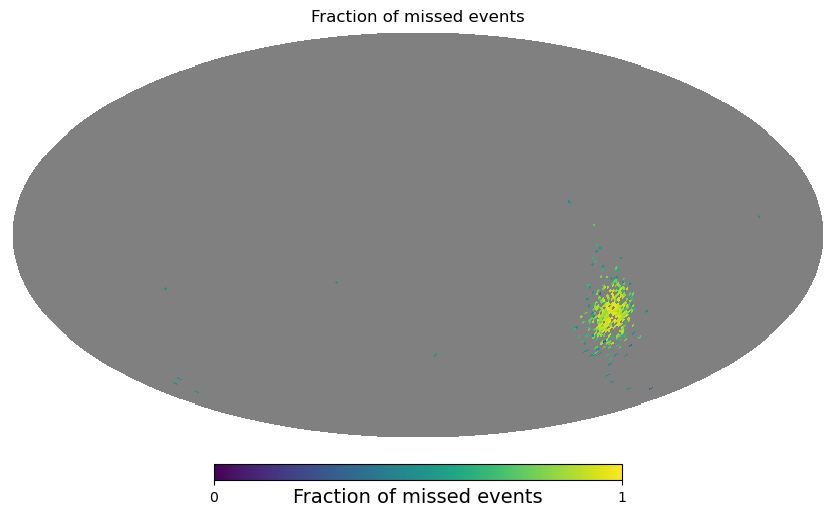

In [21]:
wnodata = (missed_early_map < 0) | (detected_early_map < 0)
frac_map = missed_early_map / (missed_early_map + detected_early_map)
frac_map[wnodata] = -1.6375e+30
hp.mollview(frac_map, 
            unit='Fraction of missed events', title='Fraction of missed events', min=0, max=1)

At least for this simulation, **missing variability coverage in the inner Bulge and Plane region** appears responsible for the drop in the fraction of possible events which are actually detected early.

### Visualizing the distribution of simulated inputs

As a check, we plot the distribution of simulated input parameters.

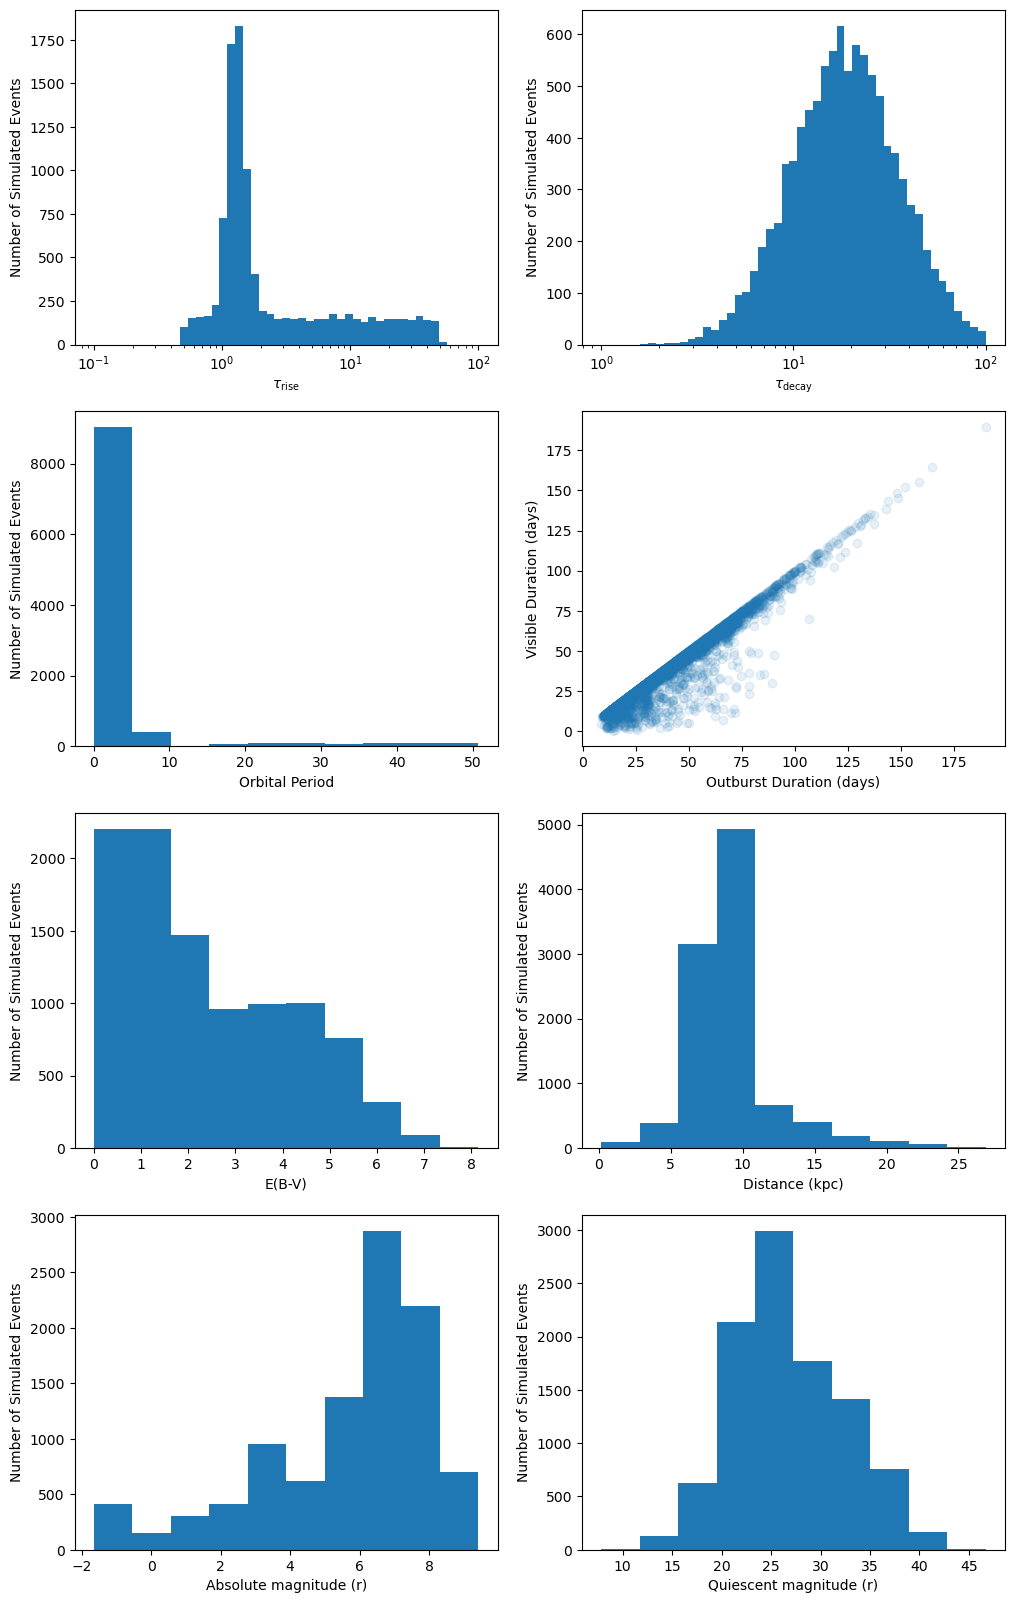

In [22]:
# plot the simulated input parameters
tau_rise = np.array([p['tau_rise'] for p in slicer.slice_points['outburst_params']])
tau_decay = np.array([p['tau_decay'] for p in slicer.slice_points['outburst_params']])
amplitude = np.array([p['amplitude'] for p in slicer.slice_points['outburst_params']])
outburst_duration = np.array([p['outburst_duration'] for p in slicer.slice_points['outburst_params']])
abs_mag_r = np.array([p['abs_mag']['r'] for p in slicer.slice_points['outburst_params']])
Porb = np.array([p['orbital_period'] for p in slicer.slice_points['outburst_params']])
visible_duration = slicer.slice_points['visible_duration']
ebv = slicer.slice_points['ebv']
distance = slicer.slice_points['distance']


distmod = 5 * np.log10(distance * 1.e3) - 5.

dust_properties = DustValues()

quiescent_mag_r = abs_mag_r + distmod + dust_properties.ax1['r']*ebv

# match the hard-coded amplitude.
peak_mag_r = quiescent_mag_r - 2.5*np.log10(amplitude)


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(12,20))
ax1.hist(tau_rise,bins=np.logspace(-1,2,50))
ax1.set_xscale('log')
ax1.set_xlabel(r'$\tau_{\rm rise}$')
ax1.set_ylabel('Number of Simulated Events')


ax2.hist(tau_decay,bins=np.logspace(0,2,50))
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau_{\rm decay}$')
ax2.set_ylabel('Number of Simulated Events')



#ax3.hist(amplitude,bins=np.logspace(2,3,50))
#ax3.set_xscale('log')
#ax3.set_xlabel('Amplitude')
#ax3.set_ylabel('Number of Simulated Events')

ax3.hist(Porb)#,bins=np.logspace(2,3,50))
#ax3.set_xscale('log')
ax3.set_xlabel('Orbital Period')
ax3.set_ylabel('Number of Simulated Events')


ax4.scatter(outburst_duration, visible_duration,alpha=0.1)#,bins=np.linspace(0,250,50))
_=ax4.set_xlabel('Outburst Duration (days)')
_=ax4.set_ylabel('Visible Duration (days)')

ax5.hist(ebv)
ax5.set_xlabel('E(B-V)')
ax5.set_ylabel('Number of Simulated Events')

ax6.hist(distance)
ax6.set_xlabel('Distance (kpc)')
ax6.set_ylabel('Number of Simulated Events')

ax7.hist(abs_mag_r)
ax7.set_xlabel('Absolute magnitude (r)')
ax7.set_ylabel('Number of Simulated Events')

ax8.hist(quiescent_mag_r)
ax8.set_xlabel('Quiescent magnitude (r)')
_=ax8.set_ylabel('Number of Simulated Events')

### How do simulated input parameters relate to detectability?

Next we look at the distribution of some key input parameters and their impact on detectability metrics.

Text(0.5, 1.0, 'Distance distribution of XRBs')

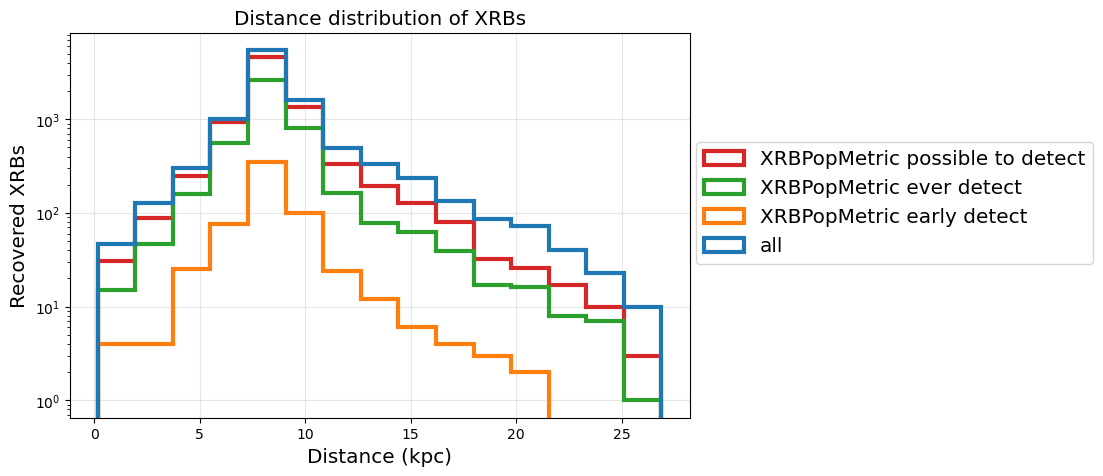

In [23]:
# Histogram of the distance distribution -- which we can also modify to show detected objects
distances = {}
distances['all'] = slicer.slice_points['distance']
for k in detect_keys:
    detected = np.where(bdict[k].metric_values == 1)
    distances[k] = distances['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([distances[k] for k in distances], 
                 label=[k.replace('_', ' ').replace('XRBPopMetric  ', '') for k in distances], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Distance (kpc)", fontsize='x-large')
plt.ylabel("Recovered XRBs", fontsize='x-large')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Distance distribution of XRBs', fontsize='x-large')

Text(0.5, 1.0, 'Duration distribution of XRBs')

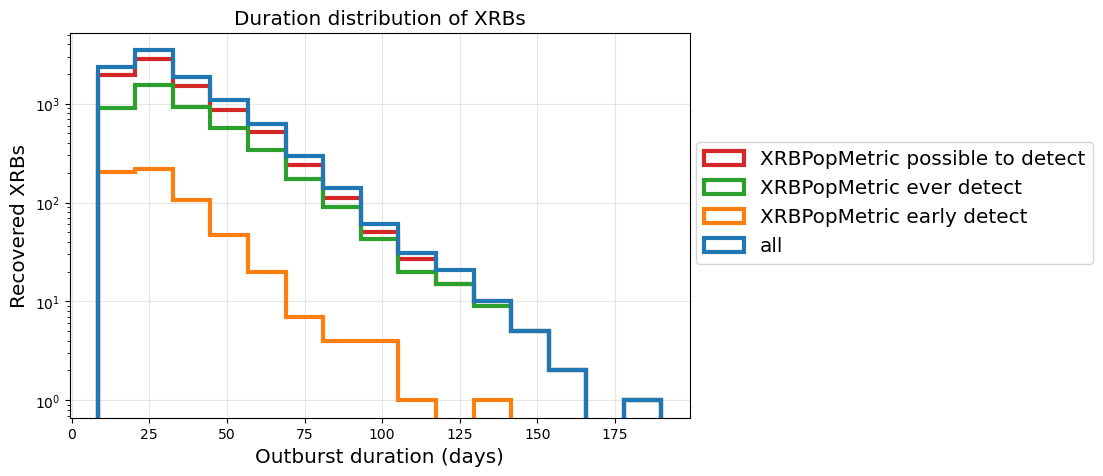

In [24]:
# And the total outburst duration distribution -- which we can also modify to show detected objects
durations = {}
durations['all'] = np.array([p['outburst_duration'] for p in slicer.slice_points['outburst_params']])
for k in detect_keys:
    detected = np.where(bdict[k].metric_values == 1)
    durations[k] = durations['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([durations[k] for k in durations], 
                 label=[k.replace('_', ' ').replace('XRBPopMetric  ', '') for k in durations], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Outburst duration (days)", fontsize='x-large')
plt.ylabel("Recovered XRBs", fontsize='x-large')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Duration distribution of XRBs', fontsize='x-large')

Text(0.5, 1.0, 'Peak magnitude distribution of XRBs')

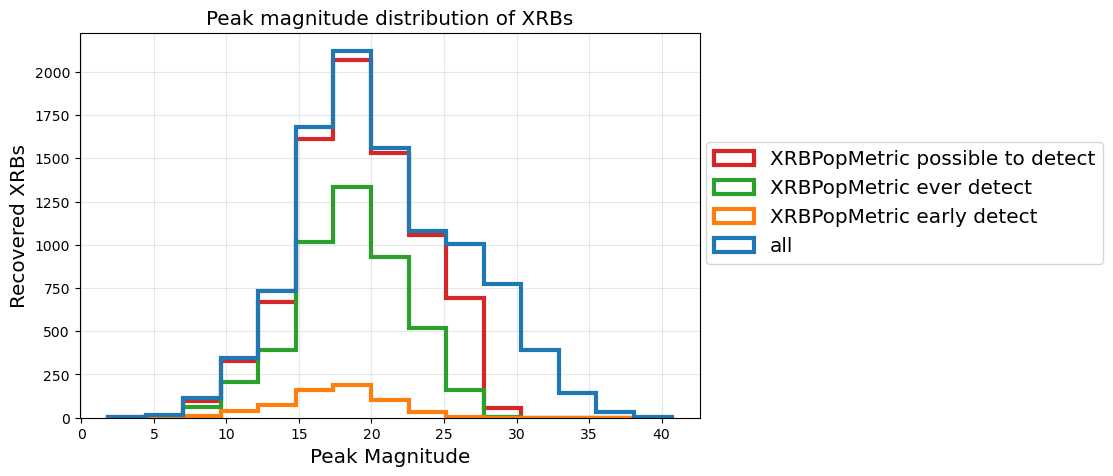

In [25]:
# And the peak_magnitude distribution -- which we can also modify to show detected objects
peak_mag = {}
peak_mag['all'] = peak_mag_r
for k in detect_keys:
    detected = np.where(bdict[k].metric_values == 1)
    peak_mag[k] = peak_mag['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([peak_mag[k] for k in peak_mag], 
                 label=[k.replace('_', ' ').replace('XRBPopMetric  ', '') for k in durations], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Peak Magnitude", fontsize='x-large')
plt.ylabel("Recovered XRBs", fontsize='x-large')
#plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Peak magnitude distribution of XRBs', fontsize='x-large')

### Lightcurve Plots 

Finally let's plot some example lightcurves, starting with the best-sampled.

In [26]:
def get_lc(v):
    """Extract lightcurves saved with `outputLc=True` from the metric datastructure
    
    Parameters
    ----------
    v : `metricValue`
        Input metricValue containing the lightcurve
    
    Returns
    -------
    lc : dict
        dict with columns `t`, `mag`, `mag_unc`, `maglim`, `filter`
    """
    if v is not None:
        return v['lc']
    else:
        return None
    
lcs = [get_lc(v) for v in bdict['xrb'].metric_values.tolist()]

In [27]:
len(lcs)

10000

In [28]:
def plot_lc(lc):
    """Helper function to plot lightcurves stored by MAF.
    """
    if lc is None:
        print('No Lightcurve')
        return
    t, mag, magerr, maglim, filt = lc
    plt.figure()
    for f in np.unique(filt):
        w = (filt == f) & (mag < 50)
        plt.errorbar(t[w],mag[w],magerr[w],fmt='.',linestyle='none',label=f)
    plt.legend()
    
    plt.xlabel('Time (MJD)')
    plt.ylabel('Magnitude')

    plt.gca().invert_yaxis()

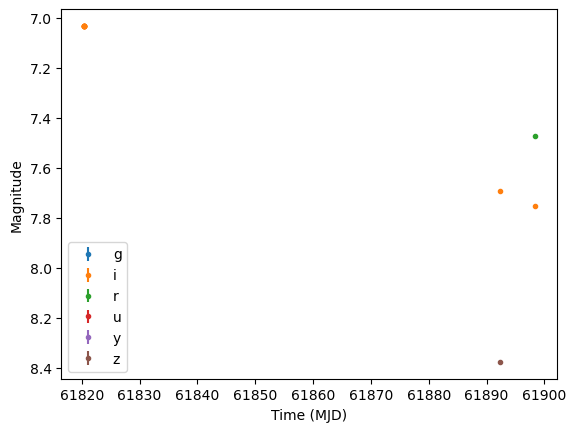

In [29]:
plot_lc(lcs[9150])

This object would of course saturate LSST, and is so bright that it would be extremely rare.  We have objects like this in our sample for two reasons: 

* In order to get good statistics, we have simulated more outbursts than we expect will occur during the LSST survey
* We have randomized LMXB and outburst parameters over the whole galaxy model, which is somewhat unrealistic--we are more likely to have already identified bright LMXBs that are close by and/or unextincted.

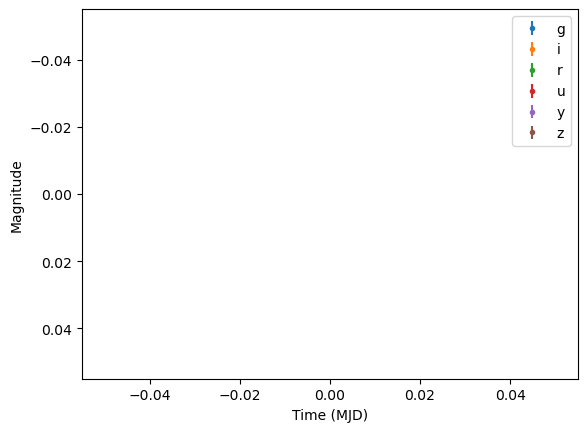

In [30]:
plot_lc(lcs[57])

This is a more characteristic lightcurve in terms of number of detections and overall brightness.